# Materials Project Database

This notebook also illustrates how we can interface with the Materials Project (MP) database. We will use the MP data retrieval tool `retrieve_MP.py` to retrieve computed bulk moduli in the form of a pandas dataframe, then apply matminer's tools to populate the dataframe with descriptors/features from pymatgen, and finally fit a linear regression model from the scikit-learn library to the dataset.

### Overview

In this notebook, we will:
1. Load and examine a dataset in a pandas dataframe
2. Add descriptors to the dataframe using matminer
3. Train and visualize a linear regression machine learning methods with scikit-learn and Plotly.

In [1]:
# Install the matminer package using pip in the current Jupyter kernel
# To use them, you may need to restart the kernel
import sys
!{sys.executable} -m pip install matminer

## 1. Load and process data set

## 1.1 Use Matminer to Obtain Data

We use matminer to load a data set of computed elastic properties of materials from MaterialsProject automatically in a pandas dataframe.

To download data from MaterialsProject, you need to create an account at https://materialsproject.org. Simply go the page, and "Sign in or Register." Then you click on "Dashboard" in the upper left of the screen and copy your API key.

You can either set the environment variable MAPI_KEY to your API key or simply add the API key in Python. To set the environment variable MAPI_KEY in Anaconda:

`conda env config vars set MAPI_KEY="api_key_from_materialsproject"`

To activate the environment variable, you need to restart Anaconda.

In [30]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

# Set your MP API key here. If set as an environment variable 'MAPI_KEY', set it to 'None'
api_key = None
mpr = MPDataRetrieval(api_key)     # Create an adapter to the MP Database.

# criteria is to get all entries with elasticity (K_VRH is bulk modulus) data
criteria = {'elasticity.K_VRH': {'$ne': None}}

# properties are the materials attributes we want
# See https://github.com/materialsproject/mapidoc for available properties you can specify
properties = ['pretty_formula', 'spacegroup.symbol', 'elasticity.K_VRH', 'formation_energy_per_atom', 'band_gap',
              'e_above_hull', 'density', 'volume', 'nsites']

# get the data!
df_mp = mpr.get_dataframe(criteria=criteria, properties=properties)
print('Number of bulk moduli extracted = ', len(df_mp))

100%|██████████| 13172/13172 [00:10<00:00, 1230.26it/s]

Number of bulk moduli extracted =  13172


## 1.2 Explore the Dataset

The data set comes as a pandas DataFrame, which is a kind of "spreadsheet" object in Python. DataFrames have several useful methods you can use to explore and clean the data, some of which we'll explore below.

In [25]:
df_mp.head()

,pretty_formula,spacegroup.symbol,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
material_id,,,,,,,,,
mp-1,Cs,Im-3m,2.0,0.038770,0.0000,0.038770,1.935039,114.051805,1
mp-1002083,CsKICl,P4/mmm,3.0,-1.834990,4.1193,0.062262,2.968000,187.068706,4
mp-1002227,RbSb,Fm-3m,6.0,0.322214,0.0000,0.741339,3.139285,109.614091,2
mp-1006112,Na3Co,Fm-3m,9.0,0.754160,0.0000,0.754160,2.156369,98.492949,4
mp-10074,GeSe2,I-42d,10.0,-0.254001,1.6631,0.000000,4.305992,177.823768,6


A pandas DataFrame includes a function called `describe()` that helps determine statistics for the various numerical / categorical columns in the data.

In [28]:
df_mp.describe()

,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
count,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000,13172.000000
mean,101.763210,-0.847532,0.671362,0.096432,6.998474,141.718257,7.763134
std,72.728987,1.013787,1.405085,0.265915,3.385482,135.430947,7.881010
min,0.000000,-4.513010,0.000000,0.000000,0.023670,5.602384,1.000000
25%,45.000000,-1.187357,0.000000,0.000000,4.474429,66.173948,4.000000
50%,85.000000,-0.536274,0.000000,0.000000,6.613811,103.096526,5.000000
75%,146.000000,-0.241757,0.556400,0.049605,8.842227,168.836892,9.000000
max,591.000000,4.412093,17.652600,4.412093,22.165012,3390.625722,160.000000


Sometimes, the `describe()` function will reveal outliers that indicate mistakes in the data. For example, negative hence unphysical minimum bulk/shear moduli or maximum bulk/shear moduli that are too high.

The data looks ok at first glance; meaning that there are no clear problems with the ranges of the various properties. Therefore, and we won't filter out any data.

Note that the `describe()` function only describes numerical columns by default.

## 1.3 Filter Out Unstable Materials and Negative Bulk Moduli

The data set above has some entries that correspond to thermodynamically or mechanically unstable materials. We filter these materials out using the distance from the convex hull and `K_VRH` (the Voight-Reuss-Hill average of the bulk modulus).

In [4]:
df = df_mp

# Remove materials with negative bulk moduli
df = df[df['elasticity.K_VRH'] > 0]

# Filter materials that are unstable by 100 meV/atom or more
# against decomposition into other phases
df = df[df['e_above_hull'] < 0.1]

df.describe()

,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites
count,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000
mean,98.768355,-0.956631,0.746245,0.011081,7.029388,151.915624,8.283585
std,68.417595,0.958849,1.465732,0.021934,3.340361,142.600369,8.305099
min,1.000000,-4.513010,0.000000,0.000000,0.107073,6.926148,1.000000
25%,45.000000,-1.248292,0.000000,0.000000,4.501844,71.102107,4.000000
50%,84.000000,-0.591223,0.000000,0.000000,6.679733,110.953545,6.000000
75%,142.000000,-0.321101,0.859500,0.010991,8.880615,179.641389,10.000000
max,551.000000,0.099251,17.652600,0.099937,22.087251,3390.625722,160.000000


## 1.4 Create a New Descriptor

We create a new desciptor for the volume per atom and add it to the pandas data frame.

In [17]:
# Add a new column to the pandas dataframe for the volume per atom as a new descriptor
df['vpa'] = df['volume']/df['nsites']

# explore columns
df.head()

,pretty_formula,spacegroup.symbol,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites,vpa,...,PymatgenData mean atomic_mass,PymatgenData std_dev atomic_mass,PymatgenData mean atomic_radius,PymatgenData std_dev atomic_radius,PymatgenData mean boiling_point,PymatgenData std_dev boiling_point,PymatgenData mean melting_point,PymatgenData std_dev melting_point,PymatgenData mean X,PymatgenData std_dev X
material_id,,,,,,,,,,,,,,,,,,,,,
mp-1,Cs,Im-3m,2.0,0.038770,0.0000,0.038770,1.935039,114.051805,1,114.051805,...,132.905452,0.000000,2.600000,0.000000,944.000000,0.000000,301.590000,0.000000,0.7900,0.000000
mp-1002083,CsKICl,P4/mmm,3.0,-1.834990,4.1193,0.062262,2.968000,187.068706,4,46.767177,...,83.590305,53.556323,1.800000,0.730297,668.127500,381.650332,299.142500,91.948374,1.8575,1.232406
mp-10074,GeSe2,I-42d,10.0,-0.254001,1.6631,0.000000,4.305992,177.823768,6,29.637295,...,76.853333,4.468915,1.183333,0.070711,1669.666667,1509.672978,733.133333,507.278405,2.3700,0.381838
mp-1009490,O2,C2/m,3.0,0.001712,1.6301,0.001712,1.140970,46.570259,2,23.285130,...,15.999400,0.000000,0.600000,0.000000,90.200000,0.000000,54.800000,0.000000,3.4400,0.000000
mp-1014013,P,Pmna,2.0,0.045053,0.8924,0.045053,0.384568,534.970620,4,133.742655,...,30.973762,0.000000,1.000000,0.000000,550.000000,0.000000,317.300000,0.000000,2.1900,0.000000


## 1.5 Add More Descriptors

We use MatMiner’s pymatgen descriptor getter tools to add some more descriptors to our dataset.

In [9]:
from matminer.featurizers.composition import ElementProperty
from matminer.utils.data import PymatgenData
from pymatgen.ext.matproj import MPRester

df["composition"] = df['pretty_formula'].map(lambda x: Composition(x))

dataset = PymatgenData()
descriptors = ['row', 'group', 'atomic_mass',
               'atomic_radius', 'boiling_point', 'melting_point', 'X']
stats = ["mean", "std_dev"]

ep = ElementProperty(data_source=dataset, features=descriptors, stats=stats)
df = ep.featurize_dataframe(df, "composition")

#Remove NaN values
df = df.dropna()
df.head()

ElementProperty:   0%|          | 0/10801 [00:00<?, ?it/s]

/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:213: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:213: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:213: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


,pretty_formula,spacegroup.symbol,elasticity.K_VRH,formation_energy_per_atom,band_gap,e_above_hull,density,volume,nsites,vpa,...,PymatgenData mean atomic_mass,PymatgenData std_dev atomic_mass,PymatgenData mean atomic_radius,PymatgenData std_dev atomic_radius,PymatgenData mean boiling_point,PymatgenData std_dev boiling_point,PymatgenData mean melting_point,PymatgenData std_dev melting_point,PymatgenData mean X,PymatgenData std_dev X
material_id,,,,,,,,,,,,,,,,,,,,,
mp-1,Cs,Im-3m,2.0,0.038770,0.0000,0.038770,1.935039,114.051805,1,114.051805,...,132.905452,0.000000,2.600000,0.000000,944.000000,0.000000,301.590000,0.000000,0.7900,0.000000
mp-1002083,CsKICl,P4/mmm,3.0,-1.834990,4.1193,0.062262,2.968000,187.068706,4,46.767177,...,83.590305,53.556323,1.800000,0.730297,668.127500,381.650332,299.142500,91.948374,1.8575,1.232406
mp-10074,GeSe2,I-42d,10.0,-0.254001,1.6631,0.000000,4.305992,177.823768,6,29.637295,...,76.853333,4.468915,1.183333,0.070711,1669.666667,1509.672978,733.133333,507.278405,2.3700,0.381838
mp-1009490,O2,C2/m,3.0,0.001712,1.6301,0.001712,1.140970,46.570259,2,23.285130,...,15.999400,0.000000,0.600000,0.000000,90.200000,0.000000,54.800000,0.000000,3.4400,0.000000
mp-1014013,P,Pmna,2.0,0.045053,0.8924,0.045053,0.384568,534.970620,4,133.742655,...,30.973762,0.000000,1.000000,0.000000,550.000000,0.000000,317.300000,0.000000,2.1900,0.000000


## 2. Fit a Linear Regression Model Using SciKitLearn

We now have a sufficiently detailed dataset to fit a linear regression model that predicts the bulk modulus. The linear model is given by
$$
y(x) = \beta_0 + \sum_{i=1}^n \beta_i x_i,
$$
where $x_i$ denotes the $n$ descriptors.


## 2.1 Define the Target Output and Relevant Descriptors

The data set above has many columns - we won't need all this data for our modeling. We try to predict `K_VRH`, the Voight-Reuss-Hill average of the bulk. We can drop most of the other output data.

In [11]:
# Target output column
y = df['elasticity.K_VRH'].values

# Possible descriptor columns
excluded = ["elasticity.K_VRH", "pretty_formula",
            "volume", "nsites", "spacegroup.symbol", "e_above_hull", "composition"]
X = df.drop(excluded, axis=1)
print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

There are 18 possible descriptors:

['formation_energy_per_atom' 'band_gap' 'density' 'vpa'
 'PymatgenData mean row' 'PymatgenData std_dev row'
 'PymatgenData mean group' 'PymatgenData std_dev group'
 'PymatgenData mean atomic_mass' 'PymatgenData std_dev atomic_mass'
 'PymatgenData mean atomic_radius' 'PymatgenData std_dev atomic_radius'
 'PymatgenData mean boiling_point' 'PymatgenData std_dev boiling_point'
 'PymatgenData mean melting_point' 'PymatgenData std_dev melting_point'
 'PymatgenData mean X' 'PymatgenData std_dev X']


## 2.2 Fit the Linear Regression Model

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

lr = LinearRegression()

lr.fit(X, y)

# get fit statistics
print('Training R2   = %.3f' % round(lr.score(X, y), 3))
print('Training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=lr.predict(X))))

Training R2   = 0.768
Training RMSE = 32.987


In [21]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n_splits=10, shuffle=True)

# compute cross validation scores for random forest model
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=crossvalidation, n_jobs=1)
print(r2_scores)
mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in mse_scores]

print('Cross-validation results:')
print('Folds: %i, mean R2   = %.3f' % (len(r2_scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE = %.3f' % (len(rmse_scores), np.mean(np.abs(rmse_scores))))

[0.79235473 0.74564171 0.77111089 0.76209722 0.77065303 0.75488591
 0.72924486 0.77074079 0.7784445  0.79405702]
Cross-validation results:
Folds: 10, mean R2   = 0.767
Folds: 10, mean RMSE = 32.954


## 2.4 Scatter Density Plot the Results with Plotly and Kernel Density Estimate

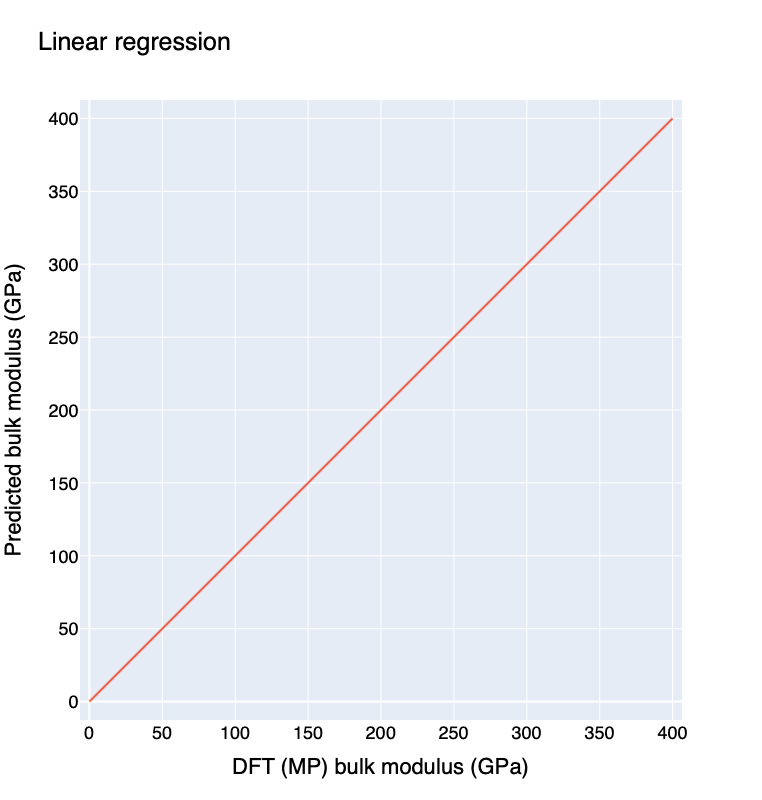

In [16]:
import plotly.graph_objects as PlotlyFig
from scipy import stats

# a line to represent a perfect model with 1:1 prediction
xy_params = {'x_col': [0, 400],
             'y_col': [0, 400],
             'color': 'black',
             'mode': 'lines',
             'legend': None,
             'text': None,
             'size': None}

xx=y
yy=lr.predict(X)

# Calculate the point density
kde = stats.gaussian_kde([xx,yy])
zz = kde([xx,yy])

# Sort the points by density, so that the densest points are plotted last
idx = zz.argsort()
xx, yy, z = xx[idx], yy[idx], zz[idx]

fig = PlotlyFig.Figure(data=PlotlyFig.Scattergl(
    x=xx,
    y=yy,
    mode='markers',
    marker=dict(
        size=5,
        color=z, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
    ),
    text=df['pretty_formula']
))

fig.update_layout(xaxis_title='DFT (MP) bulk modulus (GPa)',
                  yaxis_title='Predicted bulk modulus (GPa)',
                  title='Linear regression',
                  width=800,
                  height=800,
                  font=dict(family="Helvetica",
                            size=18, color="black")
    )

fig.update_yaxes(scaleanchor="x")

fig.add_trace(PlotlyFig.Scatter(x=[0,400], y=[0,400],
                    mode='lines'))

fig.update_layout(xaxis=dict(range=[0, 400]),
                  yaxis=dict(range=[0, 400]),
                  showlegend=False)

fig.show()

# Save image, can change format by simply changing the file suffix
# Requires kaleido package, pip install -U kaleido
#fig.write_image("images/LinearRegression.jpeg")